In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet50
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 15
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

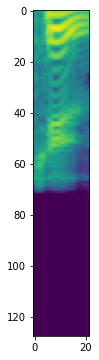

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 2):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 2):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(2)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 2)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [15]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [17]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No augmentation

In [18]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = False, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
Train
1.0249876154322872
TEST
loss: 0.810764108165618
accuracy: 0.7698924731182796
******************
epoch: 1
Train
0.43756473751304353
TEST
loss: 1.2825563953768822
accuracy: 0.7182795698924731
******************
epoch: 2
Train
0.40164246197085773
TEST
loss: 0.42575857139402823
accuracy: 0.8795698924731182
******************
epoch: 3
Train
0.2910755372971826
TEST
loss: 0.6222720742866558
accuracy: 0.8150537634408602
******************
epoch: 4
Train
0.331477822317638
TEST
loss: 0.5605479255799324
accuracy: 0.832258064516129
******************
epoch: 5
Train
0.25035020979457345
TEST
loss: 0.5743037214843175
accuracy: 0.832258064516129
******************
epoch: 6
Train
0.12337955837295976
TEST
loss: 0.3703162977131464
accuracy: 0.8924731182795699
******************
epoch: 7
Train
0.20818524329843352
TEST
loss: 0.21773072038927385
accuracy: 0.9268817204301075
******************
epoch: 8
Train
0.21431137918728851
TEST
loss: 0.3130762400165681
accuracy: 0.9053763440860215
*******

In [19]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9518072289156626


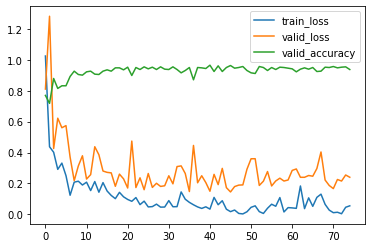

In [20]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [21]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0715034150538036
TEST
loss: 0.8154572556095738
accuracy: 0.7462365591397849
******************
epoch: 1
Train
0.5068768902882878
TEST
loss: 0.6097483945149247
accuracy: 0.8236559139784946
******************
epoch: 2
Train
0.3531532730540089
TEST
loss: 0.485972838376158
accuracy: 0.8666666666666667
******************
epoch: 3
Train
0.4093805847465832
TEST
loss: 0.3120164148269161
accuracy: 0.9139784946236559
******************
epoch: 4
Train
0.20733130780611875
TEST
loss: 0.23863402646715923
accuracy: 0.9311827956989247
******************
epoch: 5
Train
0.2478076171733772
TEST
loss: 1.74001957062752
accuracy: 0.6838709677419355
******************
epoch: 6
Train
0.3384076394762605
TEST
loss: 0.48586507407567836
accuracy: 0.843010752688172
******************
epoch: 7
Train
0.203261759086007
TEST
loss: 0.23786790874055636
accuracy: 0.9247311827956989
******************
epoch: 8
Train
0.17192715755475743
TEST
loss: 0.22771147162683547
accuracy:

In [22]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9621342512908778


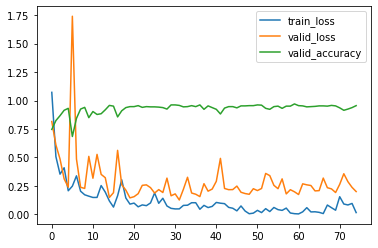

In [23]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [24]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.2552313744283583
TEST
loss: 1.0157714105421496
accuracy: 0.7053763440860215
******************
epoch: 1
Train
0.5558776919663305
TEST
loss: 0.9821385863006756
accuracy: 0.7182795698924731
******************
epoch: 2
Train
0.5173961068586309
TEST
loss: 0.28459123494804545
accuracy: 0.9032258064516129
******************
epoch: 3
Train
0.3638609540545947
TEST
loss: 0.4014972065084724
accuracy: 0.8688172043010752
******************
epoch: 4
Train
0.23350556571122838
TEST
loss: 0.41375961124256094
accuracy: 0.8731182795698925
******************
epoch: 5
Train
0.29198266327477423
TEST
loss: 0.5614528872633493
accuracy: 0.8580645161290322
******************
epoch: 6
Train
0.27373647766852804
TEST
loss: 0.3859097666958327
accuracy: 0.8924731182795699
******************
epoch: 7
Train
0.21432306532841827
TEST
loss: 0.28651570547972954
accuracy: 0.9161290322580645
******************
epoch: 8
Train
0.24093275109991055
TEST
loss: 0.1997885859781696
ac

In [25]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.955249569707401


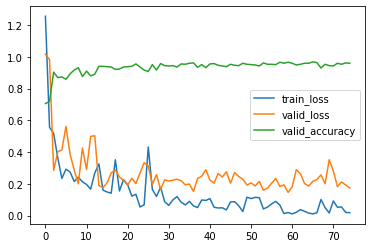

In [26]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [27]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0400398680132823
TEST
loss: 0.9223921586108464
accuracy: 0.7419354838709677
******************
epoch: 1
Train
0.4265937895048159
TEST
loss: 0.7286212916656207
accuracy: 0.8021505376344086
******************
epoch: 2
Train
0.3990754024534374
TEST
loss: 0.3960406800752045
accuracy: 0.8795698924731182
******************
epoch: 3
Train
0.3004434207032044
TEST
loss: 0.74155612286701
accuracy: 0.8150537634408602
******************
epoch: 4
Train
0.2284884130723642
TEST
loss: 0.26362454420135867
accuracy: 0.9139784946236559
******************
epoch: 5
Train
0.31311839578224887
TEST
loss: 0.5790628861996435
accuracy: 0.8279569892473119
******************
epoch: 6
Train
0.3116750760173438
TEST
loss: 0.4500113030915619
accuracy: 0.8838709677419355
******************
epoch: 7
Train
0.2161250447610661
TEST
loss: 0.6765449863608165
accuracy: 0.8172043010752689
******************
epoch: 8
Train
0.12488529517821362
TEST
loss: 0.24126446061236884
accuracy

In [28]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


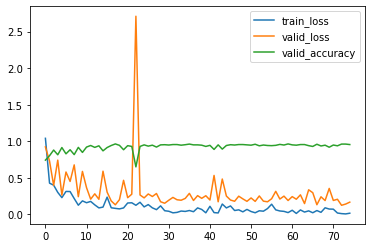

In [29]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [30]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.065308209574858
TEST
loss: 1.233423307762351
accuracy: 0.7956989247311828
******************
epoch: 1
Train
0.4158446899202477
TEST
loss: 0.7342011536321332
accuracy: 0.8086021505376344
******************
epoch: 2
Train
0.4425638122589407
TEST
loss: 0.46007848631951115
accuracy: 0.8688172043010752
******************
epoch: 3
Train
0.33161076917786975
TEST
loss: 0.42780171671221334
accuracy: 0.8881720430107527
******************
epoch: 4
Train
0.3039233335321413
TEST
loss: 0.37328945026602794
accuracy: 0.8946236559139785
******************
epoch: 5
Train
0.25855870757554894
TEST
loss: 0.32935723463694255
accuracy: 0.8946236559139785
******************
epoch: 6
Train
0.19361919817034762
TEST
loss: 0.2203997705572395
accuracy: 0.9268817204301075
******************
epoch: 7
Train
0.15780183303786274
TEST
loss: 0.15308634329547163
accuracy: 0.9440860215053763
******************
epoch: 8
Train
0.14780726359819107
TEST
loss: 0.4313816558289272
ac

In [31]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.955249569707401


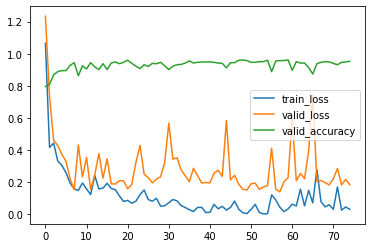

In [32]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [33]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.2493112468565415
TEST
loss: 0.9454091141300817
accuracy: 0.7483870967741936
******************
epoch: 1
Train
0.5982432073974199
TEST
loss: 0.3515386087279166
accuracy: 0.8903225806451613
******************
epoch: 2
Train
0.46614655025812907
TEST
loss: 0.5627805396433799
accuracy: 0.821505376344086
******************
epoch: 3
Train
0.41576706419468695
TEST
loss: 0.39602916301578606
accuracy: 0.8903225806451613
******************
epoch: 4
Train
0.4047851208146054
TEST
loss: 0.42518025085490235
accuracy: 0.864516129032258
******************
epoch: 5
Train
0.2730218303070379
TEST
loss: 0.5185220463301545
accuracy: 0.8731182795698925
******************
epoch: 6
Train
0.19314833931468414
TEST
loss: 0.2648284516026897
accuracy: 0.9225806451612903
******************
epoch: 7
Train
0.21022870194610244
TEST
loss: 0.35850594255232043
accuracy: 0.8946236559139785
******************
epoch: 8
Train
0.23674215516000263
TEST
loss: 0.2880669178180797
accu

In [34]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


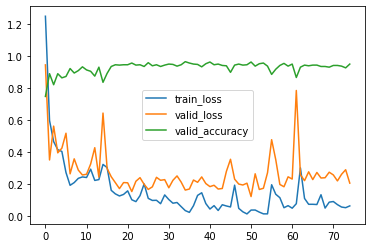

In [35]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [36]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
2.059721087536378
TEST
loss: 1.908748265748383
accuracy: 0.47096774193548385
******************
epoch: 1
Train
1.5687744531441454
TEST
loss: 1.030887471988637
accuracy: 0.6795698924731183
******************
epoch: 2
Train
1.3005607017086729
TEST
loss: 1.0591178314660186
accuracy: 0.7440860215053764
******************
epoch: 3
Train
1.188190752675473
TEST
loss: 0.8183949101355767
accuracy: 0.7526881720430108
******************
epoch: 4
Train
1.1546302630686927
TEST
loss: 1.3709482331429759
accuracy: 0.6580645161290323
******************
epoch: 5
Train
1.0846870017424026
TEST
loss: 1.547670458080948
accuracy: 0.6903225806451613
******************
epoch: 6
Train
1.0363679574135496
TEST
loss: 0.5384651066154562
accuracy: 0.8193548387096774
******************
epoch: 7
Train
1.03655476857721
TEST
loss: 0.6508203339833085
accuracy: 0.7827956989247312
******************
epoch: 8
Train
1.0579469899817957
TEST
loss: 2.68960206226636
accuracy: 0.595698

In [37]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9397590361445783


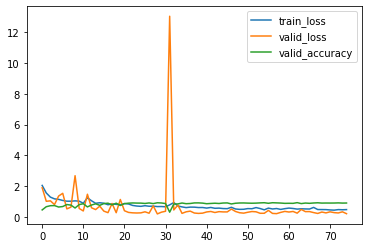

In [38]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [39]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.7221570813533884
TEST
loss: 2.3024192305021387
accuracy: 0.3655913978494624
******************
epoch: 1
Train
0.8505277091864943
TEST
loss: 1.0832665215256394
accuracy: 0.578494623655914
******************
epoch: 2
Train
0.6573101967075659
TEST
loss: 0.7692414499098255
accuracy: 0.7569892473118279
******************
epoch: 3
Train
0.5167096164448645
TEST
loss: 1.088797676819627
accuracy: 0.6365591397849463
******************
epoch: 4
Train
0.5132683006485881
TEST
loss: 0.8616700035269542
accuracy: 0.6924731182795699
******************
epoch: 5
Train
0.3886587242884225
TEST
loss: 0.5310980571213589
accuracy: 0.832258064516129
******************
epoch: 6
Train
0.25692230896341206
TEST
loss: 0.694306654122568
accuracy: 0.7935483870967742
******************
epoch: 7
Train
0.3034156293206531
TEST
loss: 0.9661810271201595
accuracy: 0.6946236559139785
******************
epoch: 8
Train
0.28754578974533285
TEST
loss: 0.7160215764917354
accuracy: 0.

In [40]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9070567986230637


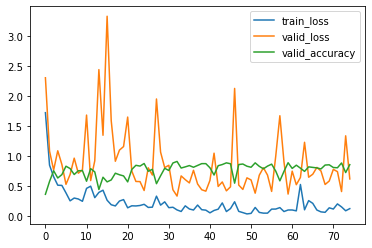

In [41]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [42]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.062450191701171
TEST
loss: 0.7913787425205272
accuracy: 0.7720430107526882
******************
epoch: 1
Train
0.5728342445806976
TEST
loss: 0.7203516669170831
accuracy: 0.789247311827957
******************
epoch: 2
Train
0.3682971075137071
TEST
loss: 0.46221723152745153
accuracy: 0.8580645161290322
******************
epoch: 3
Train
0.3435321827376473
TEST
loss: 0.30777650687002367
accuracy: 0.9010752688172043
******************
epoch: 4
Train
0.26019971898376265
TEST
loss: 0.6151956059599435
accuracy: 0.853763440860215
******************
epoch: 5
Train
0.31404475332526155
TEST
loss: 0.524697753178176
accuracy: 0.8666666666666667
******************
epoch: 6
Train
0.31236850843034125
TEST
loss: 0.5098915030238449
accuracy: 0.8494623655913979
******************
epoch: 7
Train
0.2654144509094148
TEST
loss: 0.29493437149832324
accuracy: 0.9290322580645162
******************
epoch: 8
Train
0.22208361139076657
TEST
loss: 0.238074331578388
accuracy

In [43]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


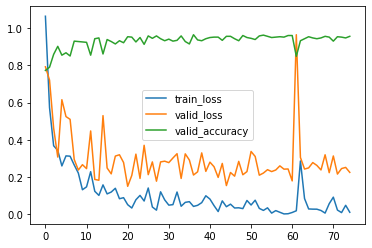

In [44]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [45]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.1213391808071762
TEST
loss: 0.5369201687074476
accuracy: 0.843010752688172
******************
epoch: 1
Train
0.47575913723528096
TEST
loss: 0.4558147195846804
accuracy: 0.853763440860215
******************
epoch: 2
Train
0.44824490036191517
TEST
loss: 0.5076930799471435
accuracy: 0.8623655913978494
******************
epoch: 3
Train
0.2644359301865967
TEST
loss: 0.45550911279134854
accuracy: 0.8903225806451613
******************
epoch: 4
Train
0.27917164243159914
TEST
loss: 0.4103798503516823
accuracy: 0.8946236559139785
******************
epoch: 5
Train
0.26306521988839443
TEST
loss: 0.7137776190234769
accuracy: 0.821505376344086
******************
epoch: 6
Train
0.2565320956174186
TEST
loss: 0.672853966682188
accuracy: 0.8236559139784946
******************
epoch: 7
Train
0.20141775739982556
TEST
loss: 0.22280273418272695
accuracy: 0.9333333333333333
******************
epoch: 8
Train
0.29346750189555737
TEST
loss: 1.3943781129775508
accura

In [46]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


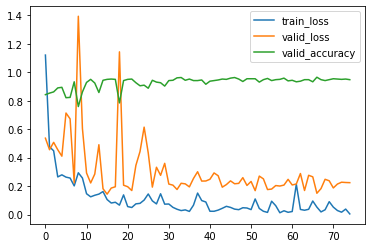

In [47]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [48]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.219261344299563
TEST
loss: 0.7198865470065865
accuracy: 0.7784946236559139
******************
epoch: 1
Train
0.526203454920985
TEST
loss: 0.41393602150742725
accuracy: 0.8774193548387097
******************
epoch: 2
Train
0.4346502159767788
TEST
loss: 0.4094158604580869
accuracy: 0.8623655913978494
******************
epoch: 3
Train
0.3468957228498813
TEST
loss: 0.5797987152171391
accuracy: 0.821505376344086
******************
epoch: 4
Train
0.31313849224091606
TEST
loss: 0.21096281260251998
accuracy: 0.9376344086021505
******************
epoch: 5
Train
0.25461683455627965
TEST
loss: 0.5172999849883458
accuracy: 0.864516129032258
******************
epoch: 6
Train
0.22575089940475274
TEST
loss: 0.21371090796685988
accuracy: 0.9311827956989247
******************
epoch: 7
Train
0.22848660548207061
TEST
loss: 0.7034388995298775
accuracy: 0.8301075268817204
******************
epoch: 8
Train
0.30083773971129535
TEST
loss: 0.7458867746014749
accura

In [49]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9655765920826161


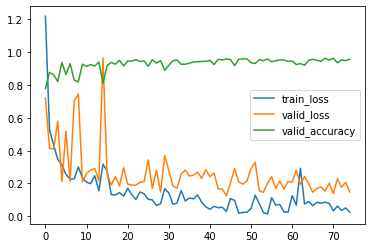

In [50]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [51]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
2.087373536058055
TEST
loss: 1.941937077942715
accuracy: 0.513978494623656
******************
epoch: 1
Train
1.5744534067781497
TEST
loss: 1.2843904577275758
accuracy: 0.6494623655913978
******************
epoch: 2
Train
1.3525232144049182
TEST
loss: 1.2457510073979696
accuracy: 0.6838709677419355
******************
epoch: 3
Train
1.2350819877353354
TEST
loss: 0.9703631977881154
accuracy: 0.7290322580645161
******************
epoch: 4
Train
1.1625109694629314
TEST
loss: 0.8068983334366994
accuracy: 0.7397849462365591
******************
epoch: 5
Train
1.0847494231158838
TEST
loss: 0.5188581314138186
accuracy: 0.8344086021505376
******************
epoch: 6
Train
1.020046815733532
TEST
loss: 0.6379606823767385
accuracy: 0.7935483870967742
******************
epoch: 7
Train
1.0338278689818416
TEST
loss: 0.8366162266782535
accuracy: 0.7247311827956989
******************
epoch: 8
Train
1.1238441594390376
TEST
loss: 0.7791752010263423
accuracy: 0.78

In [52]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9328743545611016


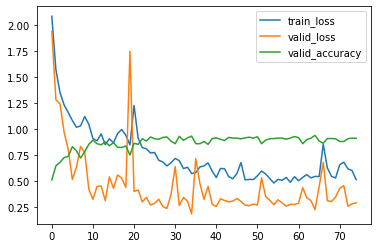

In [53]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [54]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.1672324606598097
TEST
loss: 0.713793452773043
accuracy: 0.810752688172043
******************
epoch: 1
Train
0.522600754268977
TEST
loss: 0.4530671595245279
accuracy: 0.8623655913978494
******************
epoch: 2
Train
0.4664629626543726
TEST
loss: 0.7997057309234014
accuracy: 0.853763440860215
******************
epoch: 3
Train
0.4172527032573825
TEST
loss: 0.3287999238378258
accuracy: 0.8838709677419355
******************
epoch: 4
Train
0.40912309845866346
TEST
loss: 0.23390119726298958
accuracy: 0.9354838709677419
******************
epoch: 5
Train
0.21994693277982466
TEST
loss: 0.5104881238232377
accuracy: 0.8731182795698925
******************
epoch: 6
Train
0.18068952860052892
TEST
loss: 0.2105614762793305
accuracy: 0.9333333333333333
******************
epoch: 7
Train
0.2484125752858597
TEST
loss: 0.19690166259965589
accuracy: 0.9333333333333333
******************
epoch: 8
Train
0.42171632444338575
TEST
loss: 0.28939766300621855
accurac

In [55]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


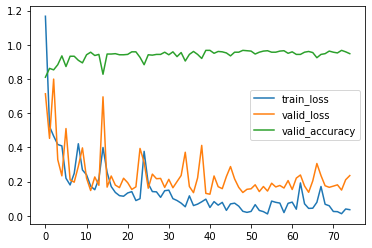

In [56]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [57]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
2.1340584312001414
TEST
loss: 1.5749709657443467
accuracy: 0.4752688172043011
******************
epoch: 1
Train
1.6705301376716644
TEST
loss: 1.889651007806101
accuracy: 0.5032258064516129
******************
epoch: 2
Train
1.459610601234128
TEST
loss: 1.8562921752211867
accuracy: 0.5655913978494623
******************
epoch: 3
Train
1.3303929196934452
TEST
loss: 1.0647767827075014
accuracy: 0.6924731182795699
******************
epoch: 4
Train
1.108235252115376
TEST
loss: 0.5131173104368231
accuracy: 0.7978494623655914
******************
epoch: 5
Train
1.0311701750010653
TEST
loss: 1.5751742673176592
accuracy: 0.5956989247311828
******************
epoch: 6
Train
1.0328910149228656
TEST
loss: 0.3747107027038451
accuracy: 0.8903225806451613
******************
epoch: 7
Train
1.0283318002440947
TEST
loss: 0.4835730869282958
accuracy: 0.8279569892473119
******************
epoch: 8
Train
1.2325902534673852
TEST
loss: 0.6933754612040776
accuracy: 0.7

In [58]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9414802065404475


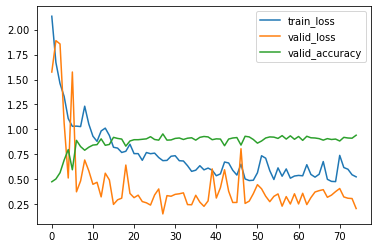

In [59]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [60]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.100535717328903
TEST
loss: 0.9071839676749321
accuracy: 0.7204301075268817
******************
epoch: 1
Train
0.4780492041787603
TEST
loss: 0.5975364892072575
accuracy: 0.843010752688172
******************
epoch: 2
Train
0.43993364127656753
TEST
loss: 0.30481926446319907
accuracy: 0.8989247311827957
******************
epoch: 3
Train
0.30322411654774833
TEST
loss: 0.46337674099911924
accuracy: 0.8602150537634409
******************
epoch: 4
Train
0.2866468715231202
TEST
loss: 0.46956391597306857
accuracy: 0.8623655913978494
******************
epoch: 5
Train
0.2286046914150462
TEST
loss: 0.43935951712310956
accuracy: 0.8709677419354839
******************
epoch: 6
Train
0.21165808943823966
TEST
loss: 0.5145315075433382
accuracy: 0.8623655913978494
******************
epoch: 7
Train
0.24263354091151274
TEST
loss: 0.30075631232992295
accuracy: 0.8989247311827957
******************
epoch: 8
Train
0.27445450283117556
TEST
loss: 0.5097852374917717
ac

In [61]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


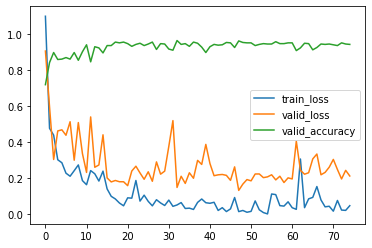

In [62]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [63]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.162269567762836
TEST
loss: 0.9684455239644615
accuracy: 0.7483870967741936
******************
epoch: 1
Train
0.6413645965153001
TEST
loss: 1.0489580098018851
accuracy: 0.7161290322580646
******************
epoch: 2
Train
0.5130720636699555
TEST
loss: 0.5510078318016504
accuracy: 0.8559139784946237
******************
epoch: 3
Train
0.41495943377591876
TEST
loss: 0.6379857915703968
accuracy: 0.8301075268817204
******************
epoch: 4
Train
0.401700754607308
TEST
loss: 0.40574234592658215
accuracy: 0.8838709677419355
******************
epoch: 5
Train
0.25871612753480366
TEST
loss: 0.2109109098872831
accuracy: 0.9182795698924732
******************
epoch: 6
Train
0.1719693681912263
TEST
loss: 0.3763902779868854
accuracy: 0.8989247311827957
******************
epoch: 7
Train
0.39983257376897313
TEST
loss: 0.29513759353468494
accuracy: 0.9032258064516129
******************
epoch: 8
Train
0.271835012479766
TEST
loss: 0.5127855165030366
accuracy

In [64]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


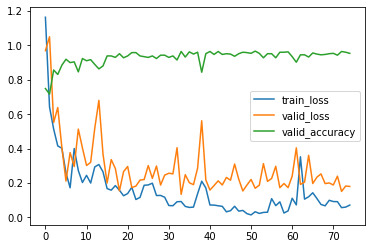

In [65]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [66]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.176101675839853
TEST
loss: 0.7383943308425206
accuracy: 0.8064516129032258
******************
epoch: 1
Train
0.4680139683367555
TEST
loss: 0.7409364775944781
accuracy: 0.7935483870967742
******************
epoch: 2
Train
0.41008663228845876
TEST
loss: 0.3821615893353698
accuracy: 0.8903225806451613
******************
epoch: 3
Train
0.2954709124167118
TEST
loss: 0.45180190237619544
accuracy: 0.8838709677419355
******************
epoch: 4
Train
0.33199785920196023
TEST
loss: 0.5746977934273341
accuracy: 0.843010752688172
******************
epoch: 5
Train
0.2776995483117843
TEST
loss: 0.287437710326205
accuracy: 0.9053763440860215
******************
epoch: 6
Train
0.14131001835236578
TEST
loss: 0.18620951528190285
accuracy: 0.9505376344086022
******************
epoch: 7
Train
0.1665702013596772
TEST
loss: 0.4334976202698164
accuracy: 0.8838709677419355
******************
epoch: 8
Train
0.2513071675351071
TEST
loss: 1.805753675327506
accuracy:

In [67]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


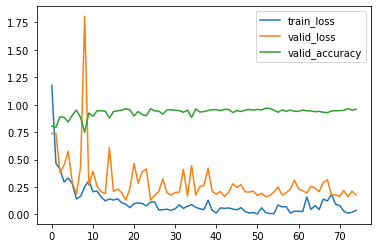

In [68]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [69]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.1165651595907051
TEST
loss: 1.9004229635320684
accuracy: 0.6516129032258065
******************
epoch: 1
Train
0.5716910110600995
TEST
loss: 0.6300035019715627
accuracy: 0.8258064516129032
******************
epoch: 2
Train
0.44885641461620424
TEST
loss: 0.683358879691811
accuracy: 0.8193548387096774
******************
epoch: 3
Train
0.3691791127173568
TEST
loss: 0.33852256251278745
accuracy: 0.9118279569892473
******************
epoch: 4
Train
0.2789762472040755
TEST
loss: 0.32009414799751773
accuracy: 0.9053763440860215
******************
epoch: 5
Train
0.2719014036596046
TEST
loss: 0.4936498313821772
accuracy: 0.8602150537634409
******************
epoch: 6
Train
0.1880873938241054
TEST
loss: 0.28943537499315
accuracy: 0.9075268817204301
******************
epoch: 7
Train
0.2129639480293086
TEST
loss: 0.3596985351013881
accuracy: 0.8903225806451613
******************
epoch: 8
Train
0.35850167937283883
TEST
loss: 0.39128668899497676
accuracy

In [70]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9483648881239243


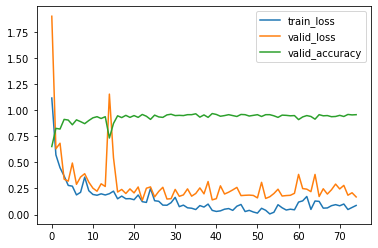

In [71]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [72]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0426216687832588
TEST
loss: 0.4745403494886173
accuracy: 0.8602150537634409
******************
epoch: 1
Train
0.46845841009769634
TEST
loss: 0.40010698597918276
accuracy: 0.886021505376344
******************
epoch: 2
Train
0.43136902335644023
TEST
loss: 0.6813031133785042
accuracy: 0.8408602150537634
******************
epoch: 3
Train
0.324049822861749
TEST
loss: 0.7616113629392398
accuracy: 0.8258064516129032
******************
epoch: 4
Train
0.3742459807655281
TEST
loss: 0.35554283035378303
accuracy: 0.9032258064516129
******************
epoch: 5
Train
0.22049203439624193
TEST
loss: 0.4105327202427772
accuracy: 0.886021505376344
******************
epoch: 6
Train
0.17419510900043453
TEST
loss: 0.2819209571967843
accuracy: 0.9096774193548387
******************
epoch: 7
Train
0.19972598811086945
TEST
loss: 0.33479148944218956
accuracy: 0.9204301075268817
******************
epoch: 8
Train
0.2525198603380927
TEST
loss: 0.6304710541361122
accur

In [73]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.963855421686747


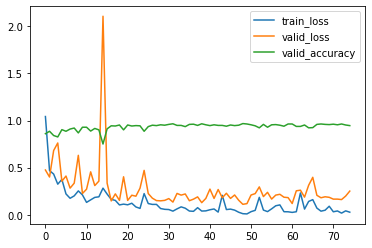

In [74]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [75]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.4261774657295156
TEST
loss: 1.6594220433183895
accuracy: 0.6473118279569893
******************
epoch: 1
Train
0.7436873395403162
TEST
loss: 0.7144227612403131
accuracy: 0.7956989247311828
******************
epoch: 2
Train
0.5667210736451896
TEST
loss: 0.31315120618830444
accuracy: 0.9010752688172043
******************
epoch: 3
Train
0.44889821451584627
TEST
loss: 0.4160143829802031
accuracy: 0.9010752688172043
******************
epoch: 4
Train
0.39958638655734946
TEST
loss: 0.40371099704055374
accuracy: 0.8731182795698925
******************
epoch: 5
Train
0.4267074665878175
TEST
loss: 0.35749997579923243
accuracy: 0.8946236559139785
******************
epoch: 6
Train
0.25859557943570083
TEST
loss: 0.2785408705152491
accuracy: 0.9139784946236559
******************
epoch: 7
Train
0.2650686892759562
TEST
loss: 0.21950824113302334
accuracy: 0.9311827956989247
******************
epoch: 8
Train
0.36028036067546154
TEST
loss: 0.3119054614856679
ac

In [76]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9466437177280551


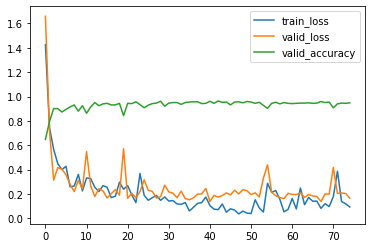

In [77]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()